# **SPAM vs. naiwny klasyfikator Bayesa**

## Wprowadzenie
Nigeryjski książę wciąż zarabia na użytkownikach elektronicznych skrzynek pocztowych ponad 700 tys. dolarów rocznie ([źródło](https://www.cnbc.com/2019/04/18/nigerian-prince-scams-still-rake-in-over-700000-dollars-a-year.html))! Jak to możliwe?

Pierwsza przyczyna jest natury psychologicznej. Ofiary są poddawane "perfekcyjnej burzy pokuszeń", jak ujął to psycholog w wywiadzie, do którego linka dałam Wam powyżej. Spammerzy łączą granie na ludzkiej chciwości, ale także na pragnieniu bycia bohaterem. W końcu kto nie chciałby zarobić na byciu wspaniałomyślnym i szczodrym? W tej kwestii możemy pracować wyłącznie nad sobą.

Możemy za to pracować nad filtrami antyspamowymi. Użyjemy techniki, która nazywa się "worek ze słowami" (bag of words) w połączeniu z naiwnym klasyfikatorem Bayesa. Choć to prosty klasyfikator, z powodzeniem jest używany współcześnie (np. [SpamAssassin](https://cwiki.apache.org/confluence/display/spamassassin/BayesInSpamAssassin)).

Notebook oparty na tutorialach:
*   https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73
*   https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038


## Import danych treningowych
https://www.kaggle.com/uciml/sms-spam-collection-dataset

To dane przygotowane przez Almeida et al. na podstawie forum brytyjskiego, gdzie użytkownicy skarżą się na spamowe SMSy. Każdy wiersz składa się z kolumny opisującej czy wiadomość jest spamem, czy nie ('spam' czy 'ham'), a druga zawiera treść wiadomości.

Jak na ćwiczeniach o regresji logistycznej, podłączamy do projektu swój dysk Google'a, aby móc skorzystać z pobranego zestawu danych:

In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [2]:
folder = '//home/feigenbaum/Downloads/' # podaj lokalizację pliku

Do pracy z danymi tekstowymi bardzo przydatna jest biblioteka [pandas](https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/).

In [3]:
import numpy as np
import pandas as pd

In [4]:
mails = pd.read_csv(folder + 'spam.csv', encoding='latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Wyczyśćmy ten zbiór danych. Usuńmy niepotrzebne kolumny i zastąpmy nazwy 'v1' i 'v2' czymś bardziej przyjaznym.

In [5]:
mails = mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
mails = mails.rename(columns={"v1": "klasa", "v2": "tekst"})
mails.head()

,klasa,tekst
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Zobaczmy jak wyglądają przykładowe dane o numerze jakimkolwiek.

In [7]:
id = 57

Treść wiadomości:

In [8]:
mails['tekst'][id]

"Sorry, I'll call later in meeting."

Kategoria:

In [9]:
mails['klasa'][id]

'ham'

Ile mamy tych maili?

In [10]:
mails.shape

(5572, 2)

## Analiza częstości występowania słów w obu klasach za pomocą biblioteki WordCloud

To biblioteka pozwalająca generować śliczne obrazki, na których wielkość słów odpowiada częstości jego występowania w danym zbiorze.

In [11]:
!pip install wordcloud
import wordcloud

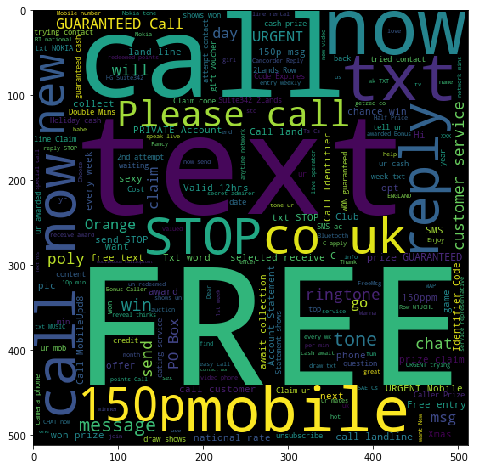

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_words = " ".join(list(mails [mails['klasa']=='spam']['tekst'] ))
spam_plot = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize=(10,8))
plt.imshow(spam_plot)

Zrób to samo dla smsów nie będących spamem:

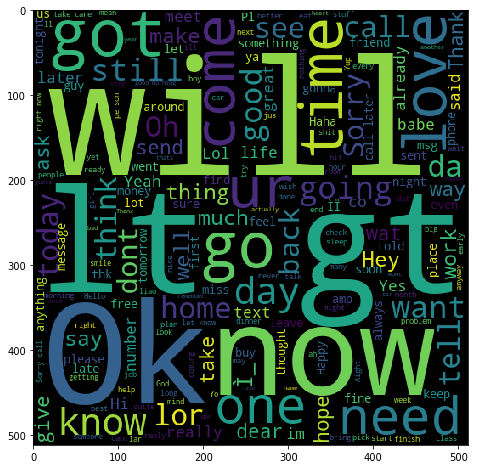

In [27]:
ham_words = " ".join(list(mails [mails['klasa']=='ham']['tekst'] ))
ham_plot = WordCloud(width = 512, height = 512).generate(ham_words)

plt.figure(figsize=(10,8))
plt.imshow(ham_plot)

Przygotujmy dane do treningu i testu klasyfikatora:

In [15]:
from sklearn.model_selection import train_test_split

X = mails.tekst
y = mails.klasa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Przekodowujemy wiadomości na wektory cech.  Korzystamy z funkcji: [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer() # stwórz instancje obiektu CountVectorizer
X_train = vectorizer.fit_transform(X_train) # naucz vectorizer słownika i przetransformuj dane uczące

Wypisz rozmiary danych treningowych:

In [17]:
print("Dane treningowe: n_samples: %d, n_features: %d" % X_train.shape)

Dane treningowe: n_samples: 3900, n_features: 7147


Dane uczące są przechowywane w macierzy rzadkiej (sparse matrix). Proszę podejrzeć jak wyglądają tak przekodowane dane:

In [18]:
print(X_train[57])

  (0, 944)	1
  (0, 3257)	1
  (0, 1644)	1
  (0, 5158)	1
  (0, 5096)	1
  (0, 1204)	2
  (0, 2953)	1
  (0, 6284)	1
  (0, 1125)	1
  (0, 6808)	1
  (0, 4318)	1
  (0, 3859)	1
  (0, 2145)	1
  (0, 6957)	1
  (0, 6433)	1
  (0, 3481)	2
  (0, 3209)	1
  (0, 6643)	1
  (0, 6840)	1
  (0, 1469)	1
  (0, 2216)	1
  (0, 2037)	1
  (0, 6400)	1


 Wektoryzujemy też dane testowe, wykorzystując już stworzony na podstawie danych treningowych wektor słów:

In [19]:
X_test = vectorizer.transform(X_test) # nie twórz nowego vectorizera, użyj gotowego, inaczej maszyna nie będzie potrafiła analizować danych testowych
print("Dane testowe: n_samples: %d, n_features: %d" % X_test.shape)

Dane testowe: n_samples: 1672, n_features: 7147


Odwrotne mapowanie z cech na słowa:

In [20]:
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

Tworzymy instancję i uczymy klasyfikator MultinomialNB

In [21]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Ocena jakości: jak zwykle będziemy korzystać z funkcji zaimplementowanych w [sci-kit](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [23]:
y_pred = clf.predict(X_test) # obliczamy predykcję dla tekstów ze zbioru testowego

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accur = accuracy_score(y_test,y_pred) # dokładność
print("Dokładność: %0.3f" % accur)

clr=classification_report(y_test,y_pred)
print("Classification report:") # wypisz raport klasyfikacji 
print(clr)
    
cm=confusion_matrix(y_test,y_pred)
print("Macierz błędów") # wypisz macierz (confusion matrix)
print(cm)

Dokładność: 0.980
Classification report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1459
        spam       0.96      0.88      0.92       213

   micro avg       0.98      0.98      0.98      1672
   macro avg       0.97      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672

Macierz błędów
[[1452    7]
 [  26  187]]


Sprawdźmy, czego właściwie maszyna się nauczyła:

In [29]:
print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
top10 = np.argsort(clf.coef_[0])[-10:]
bottom10 = np.argsort(clf.coef_[0])[:10]
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['txt' 'or' 'for' 'now' 'the' 'free' 'your' 'you' 'call' 'to']
Słowa najmniej istotne przy klasyfikacji:
['juicy' 'ned' 'neck' 'necessity' 'necessary' 'necessarily' 'necesity'
 'nearly' 'nearby' 'near']


## Zastanówmy się, czy możemy jakoś ułatwić zadanie maszynie, wykorzystując naszą znajomość języka

### Wygładzanie Laplace'a

Poszukajcie słowa, które nie występuje w zbiorze treningowym.

In [129]:
id = np.where(feature_names == 'bazinga')
print(id)

our_message = "bazinga"
vectorized_message = vectorizer.transform([our_message])
clf.predict(vectorized_message)

(array([], dtype=int64),)


array(['ham'], dtype='<U4')

### Stemming (nawet nie będę próbować tego tłumaczyć na polski, to [bogate](https://pl.bab.la/slownik/angielski-polski/stemming) znaczeniowo słowo)

Polega na ujednoliceniu słów o tym samym rdzeniu znaczeniowym (o czym maszyna, oczywiście, nie ma szans wiedzieć). Np. dzięki stemmingowi słowa "go", "going" i "goes" są przyporządkowane tylko jednemu słowu "go". Można np. użyć gotowego algorytmu stemmingowego o nazwie [Porter Stemmer](https://tartarus.org/martin/PorterStemmer/).

In [130]:
id1 = np.where(feature_names == 'going')
id2 = np.where(feature_names == 'go')
print(id1, id2)

(array([2943]),) (array([2931]),)


In [131]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

message = 'Applying classical methods of machine learning to the study of quantum systems (sometimes called quantum machine learning) is the focus of an emergent area of physics research'
words = word_tokenize(message)

stemmer = PorterStemmer()
words = [stemmer.stem(word) for word in words]

print(words)

[nltk_data] Downloading package punkt to /home/feigenbaum/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['appli', 'classic', 'method', 'of', 'machin', 'learn', 'to', 'the', 'studi', 'of', 'quantum', 'system', '(', 'sometim', 'call', 'quantum', 'machin', 'learn', ')', 'is', 'the', 'focu', 'of', 'an', 'emerg', 'area', 'of', 'physic', 'research']


Powtórzmy trening i testowanie naszego klasyfikatora na danych poddanych stemmingowi:

In [132]:
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)

In [136]:
X = mails.tekst
y = mails.klasa
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# vectorizer z PorterStemmerem został już stworzony w okienku wyżej
X_train = vectorizer.fit_transform(X_train) # naucz vectorizer słownika i przetransformuj dane uczące
X_test = vectorizer.transform(X_test) # przetransformuj dane uczące korzystając z tego samego słownika
clf = MultinomialNB()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
accur = accuracy_score(y_test,y_pred) # dokładność
print("Dokładność: %0.3f" % accur)

clr=classification_report(y_test,y_pred)
print("Classification report:") # wypisz raport klasyfikacji 
print(clr)
    
cm=confusion_matrix(y_test,y_pred)
print("Macierz błędów") # wypisz macierz (confusion matrix)
print(cm)

feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names)

print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
top10 = np.argsort(clf.coef_[0])[-10:]
bottom10 = np.argsort(clf.coef_[0])[:10]
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Dokładność: 0.986
Classification report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1439
        spam       0.97      0.93      0.95       233

   micro avg       0.99      0.99      0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672

Macierz błędów
[[1432    7]
 [  16  217]]
Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['txt' 'now' 'or' 'for' 'the' 'free' 'your' 'you' 'call' 'to']
Słowa najmniej istotne przy klasyfikacji:
['ûówell' 'lovingli' 'lovin' 'loverboy' 'lover' 'lovem' 'lovejen' 'lovli'
 'vagu' 'lov']


## Gdybyście byli spammerami... Co moglibyście zrobić, znając tę technikę antyspamową?

### Stosowanie znaków specjalnych zamiast liter

In [134]:
our_message = vectorizer.transform(['call for free'])
print(clf.predict(our_message))

our_tricky_message = vectorizer.transform(['c@ll for free'])
print(clf.predict(our_tricky_message))

['spam']
['ham']


### Wysyłanie obrazków z tekstem!
-> nakładki OCR (ang. optical character recognition)

Jakieś inne pomysły? :)

Można próbować wplatać w wiadomość fragmenty normalnego tekstu, np. z gazet lub innych źródeł, bądź dodawać nieszkodliwe losowe słowa aby zmniejszyć względną liczność występowania słów związanych ze spamem. Można temu próbować zaradzić podejmując dezycję na podstawie jedynie najbardziej znaczących prawdopodbieństw.